Verify the imports
NOTE: Please do NOT edit this panel! 

In [70]:
print('* Verifying the packages')
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

print('\t* All required packages were successfully imported!')

* Verifying the packages
	* All required packages were successfully imported!


In [110]:
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 
# Input video sequence (single sequence)   
video_sequence = '%s/../data/protocol/h2b/h2b.avi' % os.getcwd()

nameOutput='sim'

# Pixel threshold
pixel_threshold = 60

# Pixel size (should be in microns)
pixel_size = 0.088
pixel_size = 0.042

# Time step (should be in seconds)
dt = 0.200 

# Output directory 
root_output_directory = '%s/../output-protocol/' % os.getcwd()
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 

In [111]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
print('* Loading frames')
frames = video_processing.get_frames_list_from_video(
    video_path=video_sequence, verbose=True)
print('\t* Frames loaded!')
################# PLEASE DON'T EDIT THIS PANEL #################

NOTE: The output path [/ssd1/projects/hidpy/notebooks/../output-protocol/] exists
* Loading frames
	* Video Details: 
  	* Name: /ssd1/projects/hidpy/notebooks/../data/protocol/sim/sim.avi 
  	* Number Frames 20  	* FPS: 7.000000


100%|██████████████████████████████████████████████████| 20/20 [00:00<00:00, 212.42it/s]

	* Frames loaded!


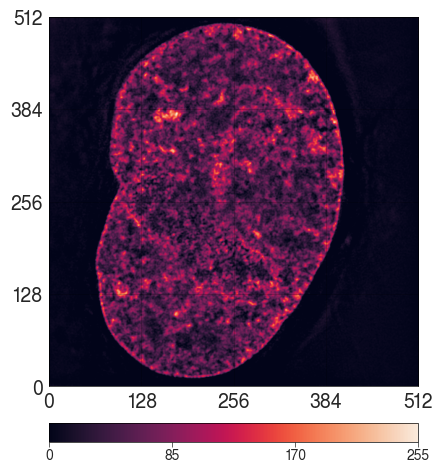

In [112]:
# Plot the first frames
plotting.plot_frame(frame=frames[0], output_directory=output_directory, frame_prefix='input_sequence_frame_0', font_size=14)

In [113]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)
print('\t* Optical flow computed!\n') 

# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)
print('\t* Interpolations computed!\n')

# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
print('\t* Trajectories created!\n')

# Plot the trajectories 
print('* Plotting trajectories')
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/trajectories' % output_directory)
print('\t* Trajectories rendered!\n')

################## PLEASE DON'T EDIT THIS PANEL #################

* Computing optical flow


100%|██████████████████████████████████████████████████| 19/19 [00:00<00:00, 21.83it/s]


Optical flow time 0.872631
	* Optical flow computed!

* Computing interpolations


100%|██████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.42it/s]


	* Interpolations computed!

* Creating trajectories


100%|██████████████████████████████████████████████████| 512/512 [00:22<00:00, 22.68it/s]


	* Trajectories created!

* Plotting trajectories
	* Trajectories rendered!



In [114]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement to microns
xp_um=xp*pixel_size
yp_um=yp*pixel_size

# extract nucleoli mask
print('* Extracting the nucleoli map')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
MSD = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Baysian fit on MSDs
print('* Fitting the MSDs models using Bayesian inference')

### THIS SHOULD BE SELECTED FROM THE CONFIG FILE 
models_selected = ['D','DA','V','DV','DAV'] 

# THE TIME STEP SHOULD BE SET IN THE CONFIG GILE 
dT = dt
Bayes = inference.apply_bayesian_inference(MSD, dT, models_selected)

* Converting the trajectories to maps
* Extracting the nucleoli map
* Computing the MSDs
* Fitting the MSDs models using Bayesian inference
Bayesian inference..
Using # cores:8


  0%|          | 8/57562 [00:00<1:19:09, 12.12it/s]<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
  0%|          | 24/57562 [00:00<29:49, 32.15it/s] <frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. E

In [115]:
# Plot the raw image

# Plot the model selection 

####################################################################################################
# @sample_range
####################################################################################################
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data


# Plot the D, A and V 
def plot_matrix(matrix, output_directory, frame_prefix, font_size=14):

    from matplotlib import colors, pyplot
    import seaborn


    #verify_plotting_packages()
    
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'

    # Plot 
    fig, ax = pyplot.subplots()
    
    # Create the ticks of the images 
    xticks = sample_range(0, matrix.shape[0], 3)
    yticks = sample_range(0, matrix.shape[1], 3)

    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
    
    # Show the image 
    im = pyplot.imshow(matrix,  interpolation='nearest',cmap=cmap,origin='lower')
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])

    # Color-bar 
    import numpy
    cb = pyplot.colorbar(im, ax=ax, cax=cax, spacing='proportional',orientation='horizontal', boundaries=[-0.5] + bounds + [5.5])
    cb.ax.tick_params(labelsize=int(font_size * 0.75), width=0.5) 
    labels = numpy.arange(0, 6, 1)
    loc = labels
    cb.set_ticks(loc)
    cb.set_ticklabels([' ','D','DA','V','DV','DAV'])
    ax.set_title('Model Selection')

    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)


In [116]:

# Plot the D, A and V 
def plot_other(matrix, matrix1, output_directory, frame_prefix, font_size=10, title='Title'):

    from matplotlib import colors, pyplot
    import seaborn


    #verify_plotting_packages()
    
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'

    # Plot 
    pyplot.clf
    fig, ax = pyplot.subplots()

  
    
    # Create the ticks of the images 
    xticks = sample_range(0, matrix.shape[0], 3)
    yticks = sample_range(0, matrix.shape[1], 3)

    # Show the image 
    im = pyplot.imshow(matrix, interpolation='nearest',cmap='viridis',origin='lower')
    ax.contour(matrix1, colors='k', origin='lower')
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_title(title)
    
    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])

    import numpy
    
    # Create the ticks based on the range 
    #cbticks = sample_range((matrix.min()), (matrix.max()), 4)
    #print(cbticks)

    #cbticks = list(map(int, cbticks))
    
    # Convert the ticks to a numpy array 
    #cbticks = numpy.array(cbticks)

    # Color-bar 
    cb = pyplot.colorbar(im, ax=ax, cax=cax, spacing='proportional',orientation='horizontal')
    cb.ax.tick_params(labelsize=int(font_size * 0.75), width=0.5) 
    #cb.ax.set_xlim((cbticks[0], cbticks[-1]))
    ax.set_title(title)

    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)

In [117]:
def plot_model_selection(img1, matrix1, output_directory, frame_prefix, font_size=10, title='Title'):

    from matplotlib import colors, pyplot
    import seaborn


    #verify_plotting_packages()
    
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'

    # Plot 
    pyplot.clf
    fig, ax = pyplot.subplots()
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
    img1=ax.imshow(Bayes['model'], interpolation='nearest',cmap=cmap,origin='lower')
    ax.contour(matrix1, colors='k', origin='lower')

    # Create the ticks of the images 
    xticks = sample_range(0, Bayes['model'].shape[0], 3)
    yticks = sample_range(0, Bayes['model'].shape[1], 3)

    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_title(title)

    cbar=fig.colorbar(img1,ax=ax,spacing='proportional',orientation='vertical',boundaries=[-0.5] + bounds + [5.5])
    import numpy as np
    labels = np.arange(0, 6, 1)
    loc = labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels([' ','D','DA','V','DV','DAV'])
    ax.set_title('Model Selection')


    # Save the figure 
    pyplot.savefig('%s/%s.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)



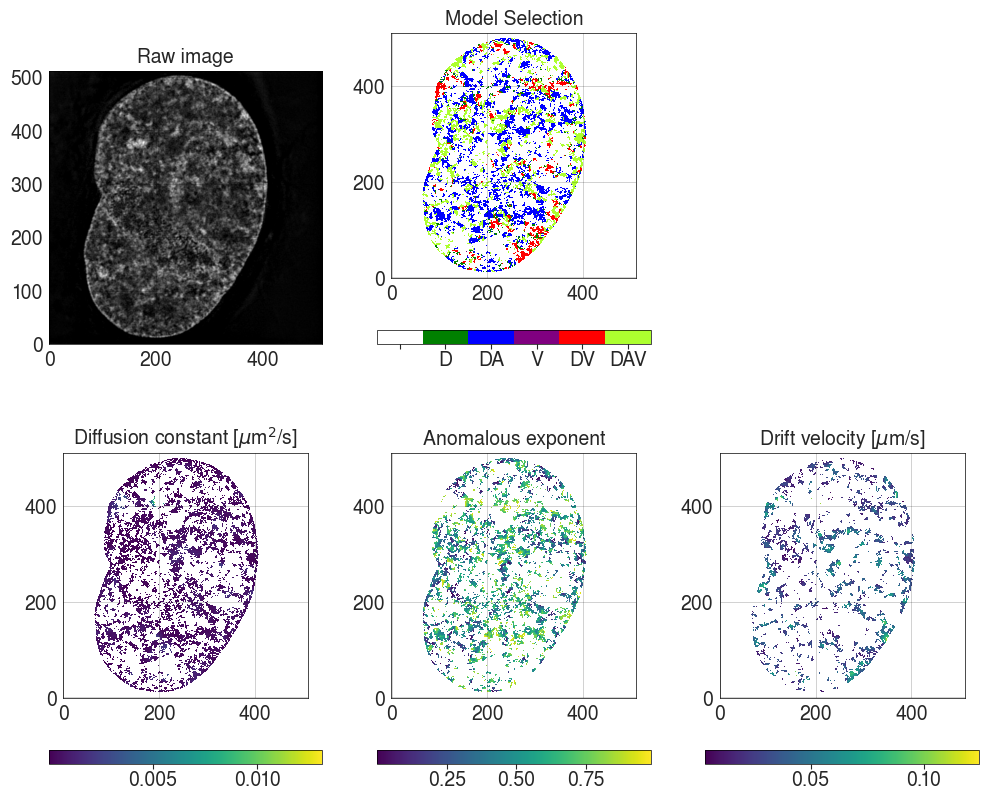

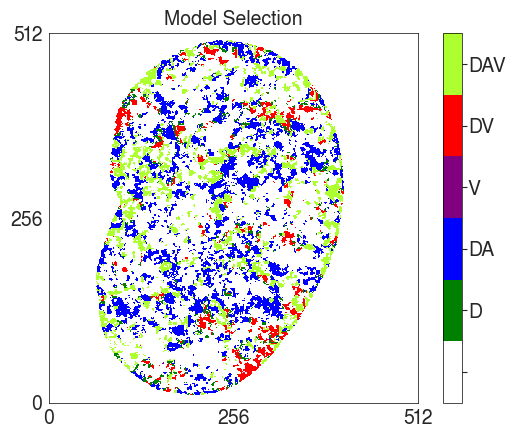

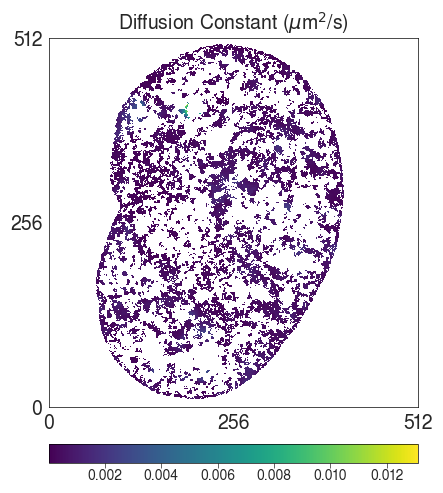

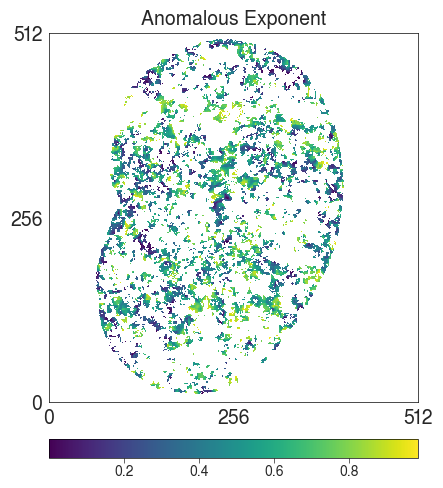

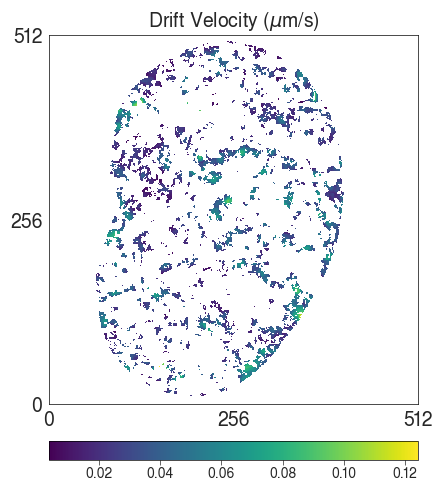

In [118]:
from pylab import *
from matplotlib import colors

matrix1=np.zeros((frames[0].shape[0],frames[0].shape[1]))
matrix1[np.where(mask_nucleoli==1)]=100

bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

fig,ax=plt.subplots(2,3,figsize=[12,10])
ax[0,2].axis('off')

img0=ax[0,0].imshow(frames[0],origin='lower',cmap='gray')
ax[0,0].set_title('Raw image')

cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
img1=ax[0,1].imshow(Bayes['model'], interpolation='nearest',cmap=cmap,origin='lower')
ax[0,1].contour(matrix1, colors='k', origin='lower')

cbar=fig.colorbar(img1,ax=ax[0,1],spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds + [5.5])
labels = np.arange(0, 6, 1)
loc = labels
cbar.set_ticks(loc)
cbar.set_ticklabels([' ','D','DA','V','DV','DAV'])
ax[0,1].set_title('Model Selection')

matD=[]
matD=Bayes['D']
matD[np.where(Bayes['model']==0)]=np.nan
matD[np.where(Bayes['D']<1e-10)]=np.nan

# #figure(2)
img2=ax[1,0].imshow(matD, interpolation='nearest', cmap='viridis', origin='lower')
ax[1,0].contour(matrix1, colors='k', origin='lower')
cbarD=fig.colorbar(img2, ax=ax[1,0],spacing='proportional',orientation='horizontal')
ax[1,0].set_title(r'Diffusion constant [$\mu$m$^2$/s]')

matA=[]
matA=Bayes['A']
matA[np.where(Bayes['model']==0)]=np.nan
matA[np.where(Bayes['A']<1e-10)]=np.nan

# #figure(3)
img3=ax[1,1].imshow(matA, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,1].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img3,ax=ax[1,1],spacing='proportional',orientation='horizontal')
ax[1,1].set_title('Anomalous exponent')

matV=[]
matV=Bayes['V']
matV[np.where(Bayes['model']==0)]=np.nan
matV[np.where(Bayes['V']==0)]=np.nan

# #figure(4)
img4=ax[1,2].imshow(matV, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,2].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img4,ax=ax[1,2],spacing='proportional',orientation='horizontal')
ax[1,2].set_title(r'Drift velocity [$\mu$m/s]')


plot_model_selection (img1=img1, matrix1=matrix1, output_directory=output_directory, frame_prefix='model', font_size=14, title='Model Selection')

plot_other(matrix=matD, matrix1=matrix1, output_directory=output_directory, frame_prefix='mat_d', font_size=14, title=r'Diffusion Constant ($\mu$m$^2$/s)')

plot_other(matrix=matA, matrix1=matrix1, output_directory=output_directory, frame_prefix='mat_a', font_size=14, title='Anomalous Exponent')

plot_other(matrix=matV, matrix1=matrix1, output_directory=output_directory, frame_prefix='mat_v', font_size=14, title=r'Drift Velocity ($\mu$m/s)')


In [69]:
# Save pickle file per cell

import pickle

output_b = output_directory + "/pickle"
os.mkdir(output_b)

with open(output_b+'/Results_Bayes_'+nameOutput+'_'+str(pixel_threshold) +'.pickle', 'wb') as f:
#with open('%s/Results_Bayes_04102022_Cell01.pickle' % output_b, 'wb') as f:
    pickle.dump(Bayes, f)